# Linear trees using LightGBM for forecasting

In this notebook we will show we can use linear trees in a gradient boosted machine model to handle time series with trend. This notebook requires installing the [`LightGBM` package](https://lightgbm.readthedocs.io/en/v3.3.4/).

In [30]:
import re
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [31]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

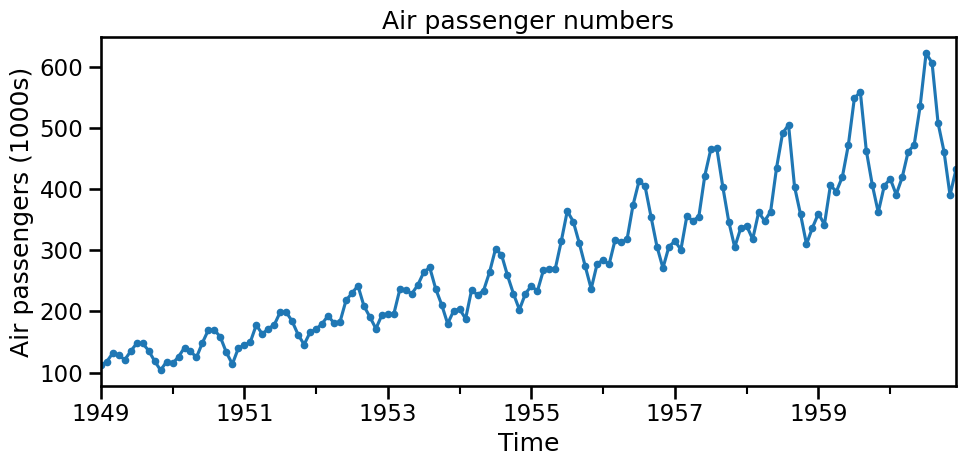

In [32]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# How to use linear trees with LightGBM

In [33]:
from lightgbm import LGBMRegressor # sklearn API

In [34]:
# Define the model.
model = LGBMRegressor(
                      boosting = "gbdt", # Gradient Boosted
                                         # Decision Trees.
                                         # Can also set `boosting`
                                         # to `rf` to use a 
                                         # Random Forest model.
                      linear_tree=True, # Use linear trees.
                      linear_lambda=0 , # L2 regularisation
                                        # for linear models 
                                        # in the leaves (i.e., Ridge).
                      n_estimators=100, # Number of boosting iterations
                                        # and therefore the number of trees.
                      bagging_freq = 1, # Required when using `rf` mode.
                                        # Ensures training samples are 
                                        # bagged (i.e, sampled without replacement)
                                        # for every tree.
                      bagging_fraction = 0.8, # Required when using `rf` mode.
                                              # Determines size of sample 
                                              # when bagging the rows.
                      feature_fraction = 0.8, # Required when using `rf` mode.
                                              # Determins size of column subset
                                              # to use for each tree.
                     )

As there are linear models in the leaves and we can use regularisation, we'll want to scale the features which is not normally necessary when working with tree-based models.

Read more about the parameters available in LightGBM [here](https://lightgbm.readthedocs.io/en/v3.3.4/Parameters.html).

# Let's build a forecast with linear trees!

In [35]:
from lightgbm import LGBMRegressor
# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# for this feature

In [36]:
# Create a copy of the data
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [37]:
target = ["y"]  # Note: it's in a list.
# This ensures we'll get
# a dataframe when using df.loc[:, target]
# rather than a pandas Series.
# This can also be useful if we have
# multiple targets.

Prepare our transformers. 

We will still build the time feature. This is because it would still allow a tree based model to segment over time and isolate changepoints, outliers, and other interesting periods during training.

In [38]:
# Prepare time feature transformer.
time_feats = make_pipeline(
                           # time sinec feature
                           TimeSince(freq="MS"), 
                           # Polinomial features    
                           PolynomialFeatures(degree=3, include_bias=False)
                          )

Create lag and window features transformer.

In [39]:
# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline all our features.

In [40]:
# Create features derived independent of one another
pipeline = make_union(
                      time_feats, 
                      lag_window_feats
)
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [41]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince(freq='MS')),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=3,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 12], 'mean': [[1, 12]]},
                 target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [42]:
pipeline.fit_transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,time_since_1949-01-01 00:00:00^3,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,,,
1949-01-01,0.000000,0.000000,0.000000e+00,0.015444,0.015444,0.015444,0.017582,0.000000
1949-02-01,0.006993,0.000049,3.419731e-07,0.015444,0.015444,0.015444,0.017582,0.000000
1949-03-01,0.013986,0.000196,2.735784e-06,0.027027,0.015444,0.015444,0.017582,0.000000
1949-04-01,0.020979,0.000440,9.233272e-06,0.054054,0.027027,0.015444,0.017582,0.000000
1949-05-01,0.027972,0.000782,2.188628e-05,0.048263,0.054054,0.027027,0.017582,0.000000
...,...,...,...,...,...,...,...,...
1960-08-01,0.972028,0.944838,9.184093e-01,1.000000,0.832046,0.710425,1.000000,0.958303
1960-09-01,0.979021,0.958482,9.383741e-01,0.969112,1.000000,0.832046,0.789011,0.969566
1960-10-01,0.986014,0.972224,9.586260e-01,0.779923,0.969112,1.000000,0.665934,0.980350


Let's reset our feature engineering pipeline.

In [43]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

In [44]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split
forecast_start_time = pd.to_datetime("1958-01-01")

# Define number of steps to forecast.
num_of_forecast_steps = 36

# Define the model.
model = LGBMRegressor(
                      boosting = "gbdt",
                      linear_tree=True, 
                      linear_lambda=0.1, 
                      n_estimators=300,
                     )

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="MS"
)

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(months=12)  # We need the latest 12 time periods
                                                    # in our predict dataframe to build our
                                                    # window features.


In [45]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# --- MODEL TRAINING---#
# Train one-step ahead forecast model
# LightGBM cannot handle column names which have
# certain characters (e.g., ":"). We replace these with `_`. 
X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))

model.fit(X_train, y_train)

# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])


# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]]

    # Predict one step ahead.
    y_pred = model.predict(X_test)

    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_forecast`. This `df_forecast`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 8
[LightGBM] [Info] Start training from score 230.898148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [46]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


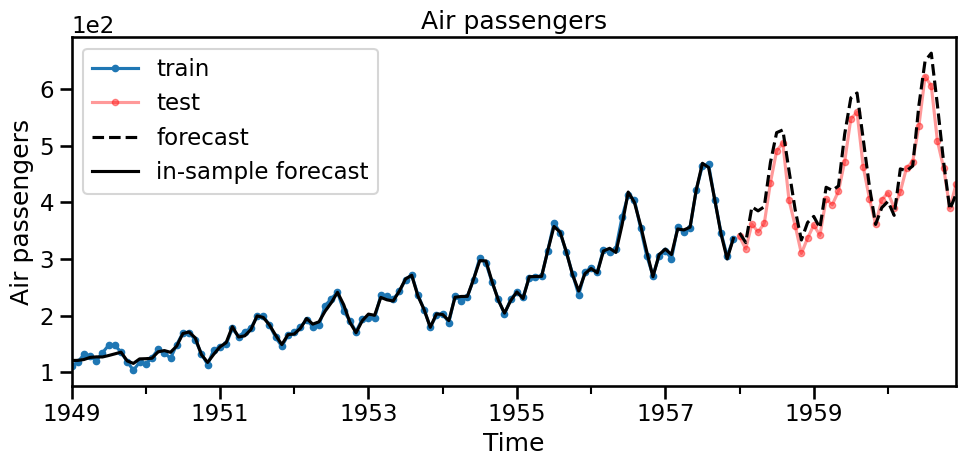

In [47]:
# --- PLOTTING FORECAST--- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])
# Plot training set.
y_train.loc[:forecast_start_time].plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", color="r", alpha=0.4)
# Plot forecast.
y_forecast.plot(ax=ax, color="k", linestyle="--")
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax, color="k", linestyle="-")

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

Let's compute the RMSE of this forecast.

In [48]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test.loc[y_forecast.index], 
                   y_forecast, 
                   squared=False)

30.00265111479364

We can now handle time series with trend natively in a tree-based model!

Feel free to change the dates, try different models, and different features!

# Useful diagnostics

We can plot the trees:

In [49]:
from lightgbm import plot_tree

ImportError: You must install graphviz and restart your session to plot tree.

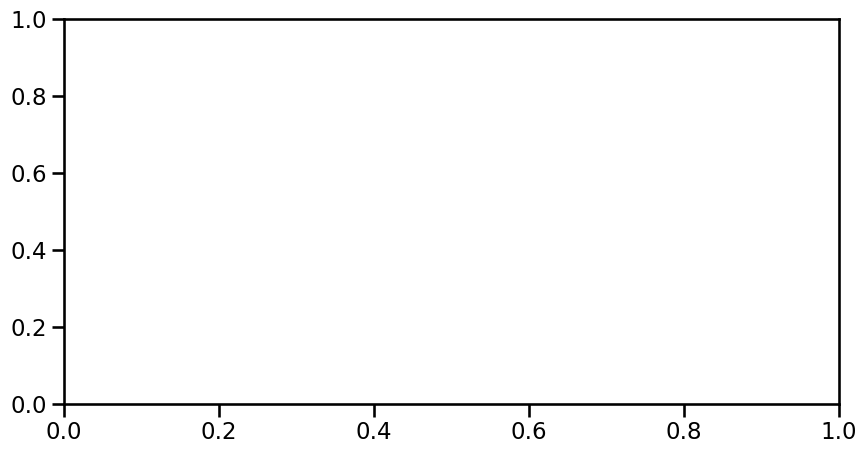

In [50]:
plot_tree(model, 
          tree_index=1, 
          figsize=(10,5), 
          orientation="vertical", 
          show_info="internal_value")

We can obtain information about a specific tree, including the linear models at the leaves, as follows:

In [ ]:
results = model.booster_.model_to_string(
                                        start_iteration=0, # Which tree to start from
                                        num_iteration=3 # Number of trees to print
                                        ) 
print(results)

tree
version=v3
num_class=1
num_tree_per_iteration=1
label_index=0
max_feature_idx=7
objective=regression
feature_names=time_since_1949_01_01_00_00_00 time_since_1949_01_01_00_00_00_2 time_since_1949_01_01_00_00_00_3 y_lag_1 y_lag_2 y_lag_3 y_lag_12 y_mean_1_12
feature_infos=[0:0.99999999999999989] [0:1] [0:1] [0:1] [0:1] [0:1] [0:1] [0:1]
tree_sizes=603 689 689

Tree=0
num_leaves=4
num_cat=0
split_feature=6 6 6
split_gain=535766 75987.1 73920.1
threshold=0.38349514563106807 0.14401294498381884 0.53883495145631077
decision_type=2 2 2
left_child=1 -1 -2
right_child=2 -3 -4
leaf_value=221.98774515455327 235.53214290684494 228.77708336321155 243.92261910413308
leaf_weight=34 21 32 21
leaf_count=34 21 32 21
internal_value=230.898 225.28 239.727
internal_weight=0 66 42
internal_count=108 66 42
is_linear=1
leaf_const=221.98774515455327 235.53214290684494 228.77708336321155 243.92261910413308
num_features=0 0 0 0
leaf_features=    
leaf_coeff=    
shrinkage=1


Tree=1
num_leaves=4
num_cat=0
s